In [25]:
import numpy as np
import glob, os
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import copy
%matplotlib inline

In [26]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/global/common/software/m1867/python/testflex/bin/python
3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:42:07) 
[GCC 9.4.0]
sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)


In [27]:
# xr.set_options(display_style='text')

In [28]:
year = '2019'
month = '01'

# os.environ["CARTOPY_USER_BACKGROUNDS"] = "/global/project/projectdirs/m1867/zfeng/globe_nasa_geotiff/"
# bkgfile = '/global/project/projectdirs/m1867/zfeng/globe_nasa_geotiff/BlueMarbleNG_2004-08-01_rgb_720x360.tiff'

topfile = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

# datadir = f'/global/cscratch1/sd/feng045/SAAG/June2018_May2019_nsp/mcstracking/20180601_20190630/'
# datadir = f'/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/GPM/mcstracking/20180601.0000_20190601.0000/'
datadir = f'/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/WRF/mcstracking/20180601.0000_20190601.0000/'

datafiles = []
dates = np.arange(25, 26, 1)
for idate in range(0, len(dates)):
#     print(f'{dates[idate]:02}')
    datafiles.extend(sorted(glob.glob(f'{datadir}mcstrack_{year}{month}{dates[idate]:02}*.nc')))
print(f'Number of files: {len(datafiles)}')
    
date_range = f'{os.path.basename(datafiles[0])[9:17]}_{os.path.basename(datafiles[-1])[9:17]}'
figdir = f'{datadir}quicklooks/{date_range}/'
os.makedirs(f'{figdir}', exist_ok=True)
print(figdir)

Number of files: 24
/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/WRF/mcstracking/20180601.0000_20190601.0000/quicklooks/20190125_20190125/


In [29]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [30]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.HGT.squeeze()
landmask = dstop.LANDMASK.squeeze()
# ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.lon
lat_ter = dstop.lat
dstop

<xarray.Dataset>
Dimensions:   (lat: 690, lon: 480, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon       (lon) float64 278.1 278.2 278.2 278.4 ... 325.7 325.8 325.9 326.0
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (lat, nbnd) float64 ...
    lon_bnds  (lon, nbnd) float64 ...
    gw        (lat) float64 ...
    area      (lat, lon) float64 ...
    HGT       (lat, lon) float32 ...
    LAKEMASK  (lat, lon) float32 ...
    LANDMASK  (lat, lon) float32 ...
    LU_INDEX  (lat, lon) float32 ...
    XTIME     datetime64[ns] ...
Attributes: (12/154)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    history:                         Wed Jun  9 11:51:55 2021: ncks -O -t 1 -...
    remap_script:                    ncremap
    remap_hostname:                  cori04
    remap_version:                   4.7.9
    map_file:                        weight_wrf_imerg_conserve.nc
    input_file:                      /global/cscratch1/sd/feng045/SAAG/map_da...

In [31]:
# Read data
ds = xr.open_mfdataset(datafiles, concat_dim='time', combine='nested', drop_variables=['longitude','latitude','cloudnumber','pcptracknumber','numclouds'])
ds.load()

<xarray.Dataset>
Dimensions:                        (time: 24, lat: 690, lon: 480)
Coordinates:
  * time                           (time) datetime64[ns] 2019-01-25 ... 2019-...
  * lat                            (lat) float32 -55.95 -55.85 ... 12.85 12.95
  * lon                            (lon) float32 278.0 278.1 ... 325.9 326.0
Data variables:
    base_time                      (time) datetime64[ns] 2019-01-25 ... 2019-...
    tb                             (time, lat, lon) float32 280.1 280.1 ... nan
    precipitation                  (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    cloudtype                      (time, lat, lon) float64 nan nan ... 0.0 0.0
    split_tracknumbers             (time, lat, lon) float64 nan nan ... nan nan
    merge_tracknumbers             (time, lat, lon) float64 nan nan ... nan nan
    cloudtracknumber_nomergesplit  (time, lat, lon) float64 nan nan ... nan nan
    cloudtracknumber               (time, lat, lon) float64 nan nan ... nan nan
Attributes:
    Title:                     Robust MCS pixel-level tracking data
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Thu Mar 17 16:35:57 2022
    startdate:                 20180601.0000
    enddate:                   20190601.0000
    precipitation_datasource:  wrf
    mcs_tb_area_thresh:        40000
    mcs_tb_duration_thresh:    4
    mcs_pf_majoraxis_thresh:   100
    mcs_pf_durationthresh:     4

In [32]:
lon = ds.lon
lat = ds.lat
# lonmin = lon.min().values
# lonmax = lon.max().values
# latmin = lat.min().values
# latmax = lat.max().values
# print(lonmin, lonmax, latmin, latmax)
ntimes = ds.dims['time']

In [33]:
lonmin, lonmax, latmin, latmax = -82, -34, -56, 13
print(lonmin, lonmax, latmin, latmax)

-82 -34 -56 13


In [37]:
def plot_map_2panels(dataarray, levels, cmaps, titles, cblabels, cbticks, timestr, figname):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-82, -34, -56, 13]
    lonv = np.arange(-80,-30.1,10)
    latv = np.arange(-50,10.1,10)
    proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=[10,8], dpi=100)
    gs = gridspec.GridSpec(2,2, height_ratios=[1,0.02], width_ratios=[1,1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.05, hspace=0.1)
    
    fig.text(0.5, 0.94, timestr, fontsize=14, ha='center')

    # Tb Panel
    ax1 = plt.subplot(gs[0,0], projection=proj)
    ax1.set_extent(map_extend, crs=proj)
    ax1.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
    ax1.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax1.set_aspect('auto', adjustable=None)
    ax1.set_title(titles[0], loc='left')
    gl = ax1.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)        
    ax1.set_xticks(lonv, crs=ccrs.PlateCarree())
    ax1.set_yticks(latv, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()        
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    cmap = plt.get_cmap(cmaps[0])
    norm = mpl.colors.BoundaryNorm(levels[0], ncolors=cmap.N, clip=True)
    data = dataarray[0]
    Zm = np.ma.masked_where((np.isnan(data)), data)
    cf1 = ax1.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
    # Overplot cloudtracknumber boundary
    tn = np.copy(dataarray[2].data)
    # Replace all valid cloudtracknumber with a constant, and invalid cloudtracknumber with 0
    tn[(tn >= 1)] = 10
    tn[np.isnan(tn)] = 0
    # Overlay boundary of cloudtracknumber on Tb
    tn1 = ax1.contour(lon, lat, tn, colors='magenta', linewidths=1, alpha=0.5, transform=ccrs.PlateCarree(), zorder=5)
    # Tb Colorbar
    cax1 = plt.subplot(gs[1,0])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[0], ticks=cbticks[0], extend='both', orientation='horizontal')
    # Terrain height
    ct = ax1.contour(lon_ter, lat_ter, ter, levels=levelshgt, colors='dimgray', linewidths=1, transform=proj, zorder=3)
    
    # Precipitation Panel
    ax2 = plt.subplot(gs[0,1], projection=ccrs.PlateCarree())
    ax2.set_extent(map_extend, crs=ccrs.PlateCarree())
    ax2.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
    ax2.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax2.set_aspect('auto', adjustable=None)
    ax2.set_title(titles[1], loc='left')
    gl = ax2.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)        
    ax2.set_xticks(lonv, crs=ccrs.PlateCarree())
    # ax2.set_yticks(latv, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()        
    ax2.xaxis.set_major_formatter(lon_formatter)
    # ax2.yaxis.set_major_formatter(lat_formatter)

    # MCS track number mask
    cmap = plt.get_cmap(cmaps[2])
    data = dataarray[2]
    norm = mpl.colors.BoundaryNorm(levels[2], ncolors=cmap.N, clip=True)
    Zm = np.ma.masked_invalid(data)
    cm1 = ax2.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2, alpha=0.7)
    
    # Precipitation
    cmap = plt.get_cmap(cmaps[1])
    norm = mpl.colors.BoundaryNorm(levels[1], ncolors=cmap.N, clip=True)
    data = dataarray[1]
    Zm = np.ma.masked_where(((data < 2)), data)
    cf2 = ax2.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
    # Colorbar
    cax2 = plt.subplot(gs[1,1])
    cb2 = plt.colorbar(cf2, cax=cax2, label=cblabels[1], ticks=cbticks[1], extend='both', orientation='horizontal')
    # Terrain height
    ct = ax2.contour(lon_ter, lat_ter, ter, levels=levelshgt, colors='dimgray', linewidths=1, transform=proj, zorder=3)

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

2019-01-25 10:00 UTC


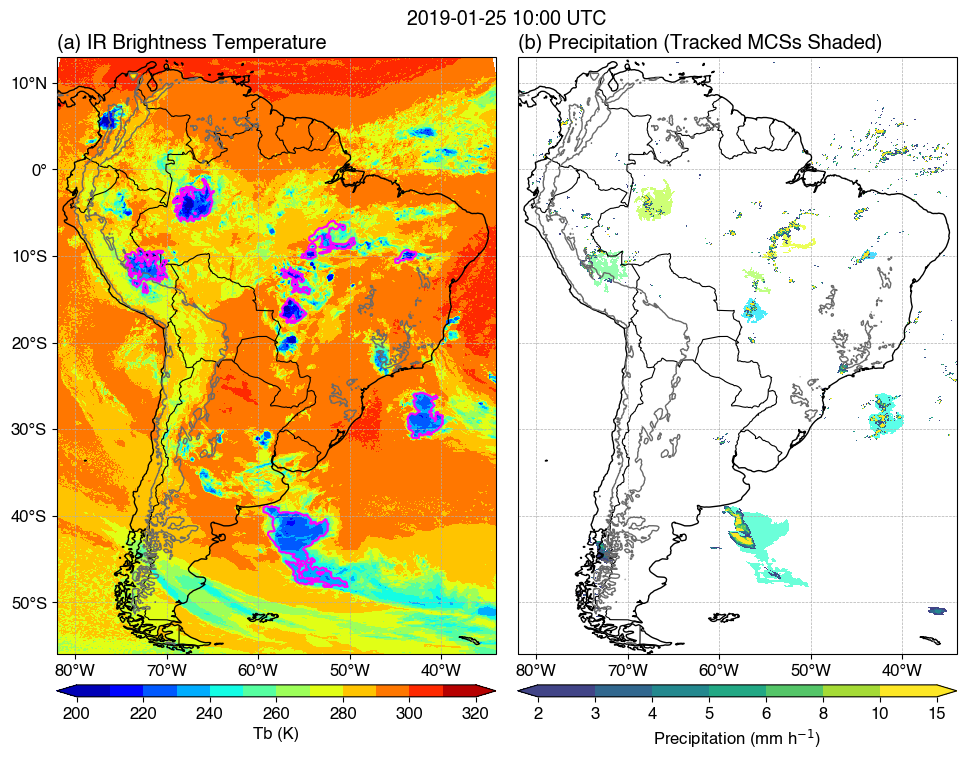

In [38]:
pcplev = [2,3,4,5,6,8,10,15]
tnlev = np.arange(ds.cloudtracknumber.min(), ds.cloudtracknumber.max(), 1)
levels = [np.arange(200, 320.1, 10), pcplev, tnlev]
cbticks = [np.arange(200, 320.1, 20), pcplev]
cblabels = ['Tb (K)', 'Precipitation (mm h$^{-1}$)']
# cmap_pcp = generate_NCL_cmap('precip3_16lev', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB')
# cmap_pcp = truncate_colormap(cmap_pcp, minval=0.2, maxval=1)
cmap_tb = truncate_colormap(plt.get_cmap('jet'), minval=0.05, maxval=0.95)
cmap_pcp = truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=1.0)
cmap_mcs = truncate_colormap(plt.get_cmap('jet_r'), minval=0.05, maxval=0.95)
cmaps = [cmap_tb, cmap_pcp, cmap_mcs]
# cmaps = ['jet', 'Blues_r', 'jet']
titles = ['(a) IR Brightness Temperature','(b) Precipitation (Tracked MCSs Shaded)']

# Loop over each time
itime = 10
# for itime in range(0, ntimes):
dataarr = [ds.tb.isel(time=itime), ds.precipitation.isel(time=itime), ds.cloudtracknumber.isel(time=itime)]
fdatetime = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y%m%d_%H%M')
timestr = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y-%m-%d %H:%M UTC')
figname = f'{figdir}{fdatetime}.png'
print(timestr)
fig = plot_map_2panels(dataarr, levels, cmaps, titles, cblabels, cbticks, timestr, figname)

In [36]:
figdir

'/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/WRF/mcstracking/20180601.0000_20190601.0000/quicklooks/20190125_20190125/'

In [34]:
pcplev = [2,3,4,5,6,8,10,15]
# pcplev = [1,2,3,4,5,7,10,15]
tnlev = np.arange(ds.cloudtracknumber.min(), ds.cloudtracknumber.max(), 1)
levels = [np.arange(200, 320.1, 10), pcplev, tnlev]
cbticks = [np.arange(200, 320.1, 20), pcplev]
cblabels = ['Tb (K)', 'Precipitation (mm h$^{-1}$)']
cmap_tb = truncate_colormap(plt.get_cmap('jet'), minval=0.05, maxval=0.95)
cmap_pcp = truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=1.0)
cmap_mcs = truncate_colormap(plt.get_cmap('jet_r'), minval=0.05, maxval=0.95)
cmaps = [cmap_tb, cmap_pcp, cmap_mcs]
# cmaps = ['jet', 'Blues_r', 'jet']
titles = ['(a) IR Brightness Temperature','(b) Precipitation (Tracked MCSs Shaded)']

# Loop over each time
for itime in range(0, ntimes):
    dataarr = [ds.tb.isel(time=itime), ds.precipitation.isel(time=itime), ds.cloudtracknumber.isel(time=itime)]
    fdatetime = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y%m%d_%H%M')
    timestr = pd.to_datetime(ds.time.isel(time=itime).values).strftime('%Y-%m-%d %H:%M UTC')
    figname = f'{figdir}{fdatetime}.png'
    print(timestr)
    fig = plot_map_2panels(dataarr, levels, cmaps, titles, cblabels, cbticks, timestr, figname)
    plt.close(fig)

2019-01-25 00:00 UTC
2019-01-25 00:59 UTC
2019-01-25 01:59 UTC
2019-01-25 02:59 UTC
2019-01-25 04:01 UTC
2019-01-25 05:00 UTC
2019-01-25 06:00 UTC
2019-01-25 07:00 UTC
2019-01-25 08:00 UTC
2019-01-25 08:59 UTC
2019-01-25 09:59 UTC
2019-01-25 10:59 UTC
2019-01-25 11:58 UTC
2019-01-25 13:00 UTC
2019-01-25 14:00 UTC
2019-01-25 15:00 UTC
2019-01-25 16:00 UTC
2019-01-25 16:59 UTC
2019-01-25 17:59 UTC
2019-01-25 18:59 UTC
2019-01-25 20:01 UTC
2019-01-25 21:00 UTC
2019-01-25 22:00 UTC
2019-01-25 23:00 UTC


In [ ]:
# cmap = plt.get_cmap('jet')
# data = dataarr[2]
# tnmin = data.min().values
# tnmax = data.max().values
# tnlev = np.arange(tnmin, tnmax, 1)
# norm = mpl.colors.BoundaryNorm(tnlev, ncolors=cmap.N, clip=True)
# Zm = np.ma.masked_invalid(data)
# cm1 = plt.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, alpha=0.3)

In [ ]:
# itime = 0
# cmap = plt.get_cmap('viridis')
# # pcplev = [1,2,3,5,7,10,14,20]
# pcplev = [1,2,3,5,7,10,15]
# norm = mpl.colors.BoundaryNorm(pcplev, ncolors=cmap.N, clip=True)
# data = ds.precipitation.isel(time=itime)
# Zm = np.ma.masked_where((data < 1), data)
# plt.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap)
# plt.colorbar()